In [2]:
import jax
import jax.numpy as jnp
import flox

In [9]:
from flox.util import key_chain


seed = 42
chain = key_chain(42)

In [3]:
dim = 2
num_particles = 20

In [13]:
from jax_dataclasses import pytree_dataclass

from jaxtyping import Float, Array  # type: ignore

Particles = Float[Array, "P D"]
Auxiliaries = Float[Array, "P F"]

@pytree_dataclass(frozen=True)
class State:
    p: jnp.ndarray
    q0: jnp.ndarray
    q1: jnp.ndarray

In [ ]:
resolution = (32, 32)

In [168]:
from typing import cast
import haiku as hk

from flox._src.bulk.lattice import AggregationMethod, neighbors

def indices_and_weights(pos, resolution):
    idx = jax.vmap(flox.bulk.lattice_indices, in_axes=(0, None, None))(pos, flox.bulk.neighbors(pos.shape[-1]), resolution)
    weights = jax.vmap(flox.bulk.lattice_weights, in_axes=(0, 0, None))(pos, idx, resolution)
    return idx, weights


class GaugeConvNet(hk.Module):

    def __init__(self, num_out, resolution):
        super().__init__()
        self.num_out = num_out
        self.resolution = resolution

    def __call__(self, idx, weights, sig):
        dim = sig.shape[-1]
        kernel = hk.get_parameter(
            "kernel",
            shape=(3 ** dim, sig.shape[-2], self.num_out),
            init=hk.initializers.TruncatedNormal()
        )
        # bias = hk.get_parameter(
        #     "bias", shape=(self.num_out, 1),
        #     init=hk.initializers.Constant(0.)
        # )
        sig = flox.bulk.scatter(sig, weights, idx, self.resolution)
        other = flox.bulk.gather(sig, idx, AggregationMethod.Nothing)
        focus = cast(Array, other[:, 4])
        out = jax.vmap(flox.bulk.gauge_conv, in_axes=(0, 0, None, None))(
            focus, other, neighbors(dim), kernel
        ) #+ bias
        return out


class Linear(hk.Module):
    
    def __init__(self, num_out):
        super().__init__()
        self.num_out = num_out

    def __call__(self, x):
        stddev = 1./jnp.sqrt(x.shape[-2] + self.num_out)
        w = hk.get_parameter(
            "weight",
            shape=(x.shape[-2], self.num_out),
            init=hk.initializers.TruncatedNormal(stddev=stddev))
        return jnp.einsum("...fd, fg -> ...gd", x, w)


class GaugeResNet(hk.Module):

    def __init__(self, num_layers, num_hidden, num_out, resolution, activation, output_residual):
        super().__init__()
        self.num_hidden = num_hidden
        self.resolution = resolution
        self.activation = activation
        self.num_layers = num_layers
        self.num_out = num_out
        self.output_residual = output_residual

    def __call__(self, idx, weights, signal):
        def body(signal) -> Array:
            out = GaugeConvNet(self.num_hidden, self.resolution)(idx, weights, signal)
            return signal + self.activation(out)

        out = Linear(self.num_hidden)(signal)
        out = hk.experimental.layer_stack(self.num_layers)(body)(out)
        out = Linear(self.num_out)(out)
        if self.output_residual:
            if signal.shape[-2] in (self.num_out, 1):
                return signal + out
            else:
                raise ValueError(f"Cannot broadcast output residual."\
                                 f"Input channels: {signal.shape[-2]}, "\
                                 f"Oututput channels: {self.num_out}.")
        else:
            return signal

In [261]:

from flox._src.flow.api import Transformed
from flox._src.geom.manifold import Manifold, PointN
from flox.flow import Affine, Lambda

def indices_and_weights(pos, resolution):
    idx = jax.vmap(flox.bulk.lattice_indices, in_axes=(0, None, None))(pos, flox.bulk.neighbors(pos.shape[-1]), resolution)
    weights = jax.vmap(flox.bulk.lattice_weights, in_axes=(0, 0, None))(pos, idx, resolution)
    return idx, weights

class AuxUpdater(hk.Module):

    def __init__(self, field, num_layers, num_hidden, num_out, resolution, activation):
        super().__init__()
        self.field = field
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.num_out = num_out
        self.resolution = resolution
        self.activation = activation

    def __call__(self, state: State):
        idx, weights = indices_and_weights(state.p, self.resolution)
        params = GaugeResNet(
            self.num_layers,
            self.num_hidden,
            self.num_out,
            self.resolution,
            self.activation,
            True
        )(idx, weights, self.field(state))
        shift, scale = jnp.split(params, 2, axis=-2)
        shift = shift.sum(axis=-2, keepdims=True) * 1e-4
        scale = jnp.sqrt(1e-12 + jnp.square(scale.sum(axis=-2, keepdims=True)).sum(axis=-1, keepdims=True)) * 1e-4
        return Affine(shift, scale)

class PosUpdater(hk.Module):

    def __init__(self, manifold: Manifold):
        super().__init__()
        self.manifold = manifold

    def __call__(self, state: State) -> Lambda[PointN, PointN]:
        shift = state.q0.sum(axis=-2)
        
        def shift_fn(x, shift) -> Transformed[PointN]:
            return Transformed(self.manifold.shift(x, shift), jnp.zeros(()))
        
        return Lambda(
            forward=lambda x: shift_fn(x, shift),
            inverse=lambda x: shift_fn(x, -shift)
        )

In [262]:
from flox.geom import Torus

torus = Torus(jnp.ones(dim))

In [271]:
dmin = 0.1

In [272]:
from functools import partial

relax = flox.bulk.relax(
    torus.shift,
    flox.bulk.pairwise_penalty(
        partial(flox.bulk.soft_edge, dmin=dmin),
        torus
    )
)

In [273]:
sigma = jnp.power(2, 1./6.) * dmin
soften = 1e-5

lennard_jones_potential = flox.bulk.pairwise_penalty(
    partial(flox.bulk.lennard_jones_edge, sigma=sigma, soften=soften),
    torus
)

In [274]:
import haiku as hk
import lenses
from flox._src.flow.api import Transform
from flox._src.flow.impl import Affine
from flox._src.util.func import Lens
from flox.bulk import gauge_conv
import flox.nn as fnn

class Relaxation(hk.Module):
    def __call__(self, s: State):
        _, dq = relax(s.p)
        dq = dq[..., None, :]
        return Affine(dq, jnp.zeros_like(dq))


def get_q0(state: State):
    return state.q0

def update_q0(state: State, new):
    return lenses.bind(state).q0.set(new)

def get_q1(state: State):
    return state.q1

def update_q1(state: State, new):
    return lenses.bind(state).q1.set(new)

def get_pos(state: State):
    return state.p

def update_pos(state: State, new):
    return lenses.bind(state).p.set(new)


def make_aux_coupling() -> Transform[State, State]:
    return flox.flow.Pipe([
        flox.flow.SimpleCoupling(
            AuxUpdater(
                get_q0,
                2, 64, 2, (32, 32), jax.nn.silu,
            ),
            Lens(get_q1, update_q1)
        ),
        flox.flow.SimpleCoupling(
            AuxUpdater(
                get_q1,
                2, 64, 2, (32, 32), jax.nn.silu,
            ),
            Lens(get_q0, update_q0)
        )

    ])

def make_inner_flow(num_blocks) -> Transform[State, State]:
    return flox.flow.Pipe([
        flox.nn.haiku.LayerStack(make_aux_coupling, num_layers=num_blocks),
        flox.flow.SimpleCoupling(
            PosUpdater(torus),
            Lens(get_pos, update_pos)
        )
    ])

def make_full_flow(num_blocks) -> Transform[State, State]:
    return flox.flow.Pipe([
        flox.flow.SimpleCoupling(
            Relaxation(),
            Lens(get_q0, update_q0)
        ),
        make_inner_flow(num_blocks),
    ])

flow = flox.nn.haiku.to_haiku(partial(make_full_flow, num_blocks=2))

In [275]:
from flox.flow import Transformed 

num_particles = 100

p = jax.random.uniform(next(chain), shape=(num_particles, dim))
q0 = jax.random.normal(next(chain), shape=(num_particles, 1, dim)) * 1e-3
q1 = jax.random.normal(next(chain), shape=(num_particles, 1, dim)) * 1e-3

params = jax.jit(flow.pure.init)(
    next(chain),
    State(p, q0, q1)
)

In [276]:
# p_, dq = jax.jit(relax)(p)
# plt.scatter(*torus.shift(p, dq).T)

In [280]:
p = jax.random.uniform(next(chain), shape=(num_particles, dim))
q0 = jax.random.normal(next(chain), shape=(num_particles, 1, dim)) * 1e-3
q1 = jax.random.normal(next(chain), shape=(num_particles, 1, dim)) * 1e-3

out = jax.jit(flow.with_params(params).forward)(
    State(p, q0, q1)
)



In [281]:
lennard_jones_potential(
    out.obj.p
)

DeviceArray(0.40552136, dtype=float32)

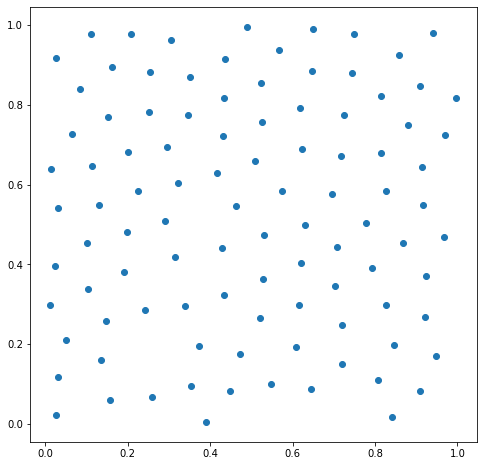

In [282]:
from matplotlib import pyplot as plt


plt.figure(figsize=(8, 8))
plt.scatter(*out.obj.p.T)